# Modelling the market dynamics of a stable coin (SAI, single collateral DAI)

We set out to model how the market price of SAI responds to changes in the Maker's stability fee. We suppose the existence of a "debt price": a sort of _"intrinsic value"_ of SAI derived from the activity in the debt system. We then define the market dynamics as being the same of a PID controller correcting for two errors:
* the difference between the market price and the debt price
* the difference between the market price and the target price (which in Maker's case was constant and equal to 1)

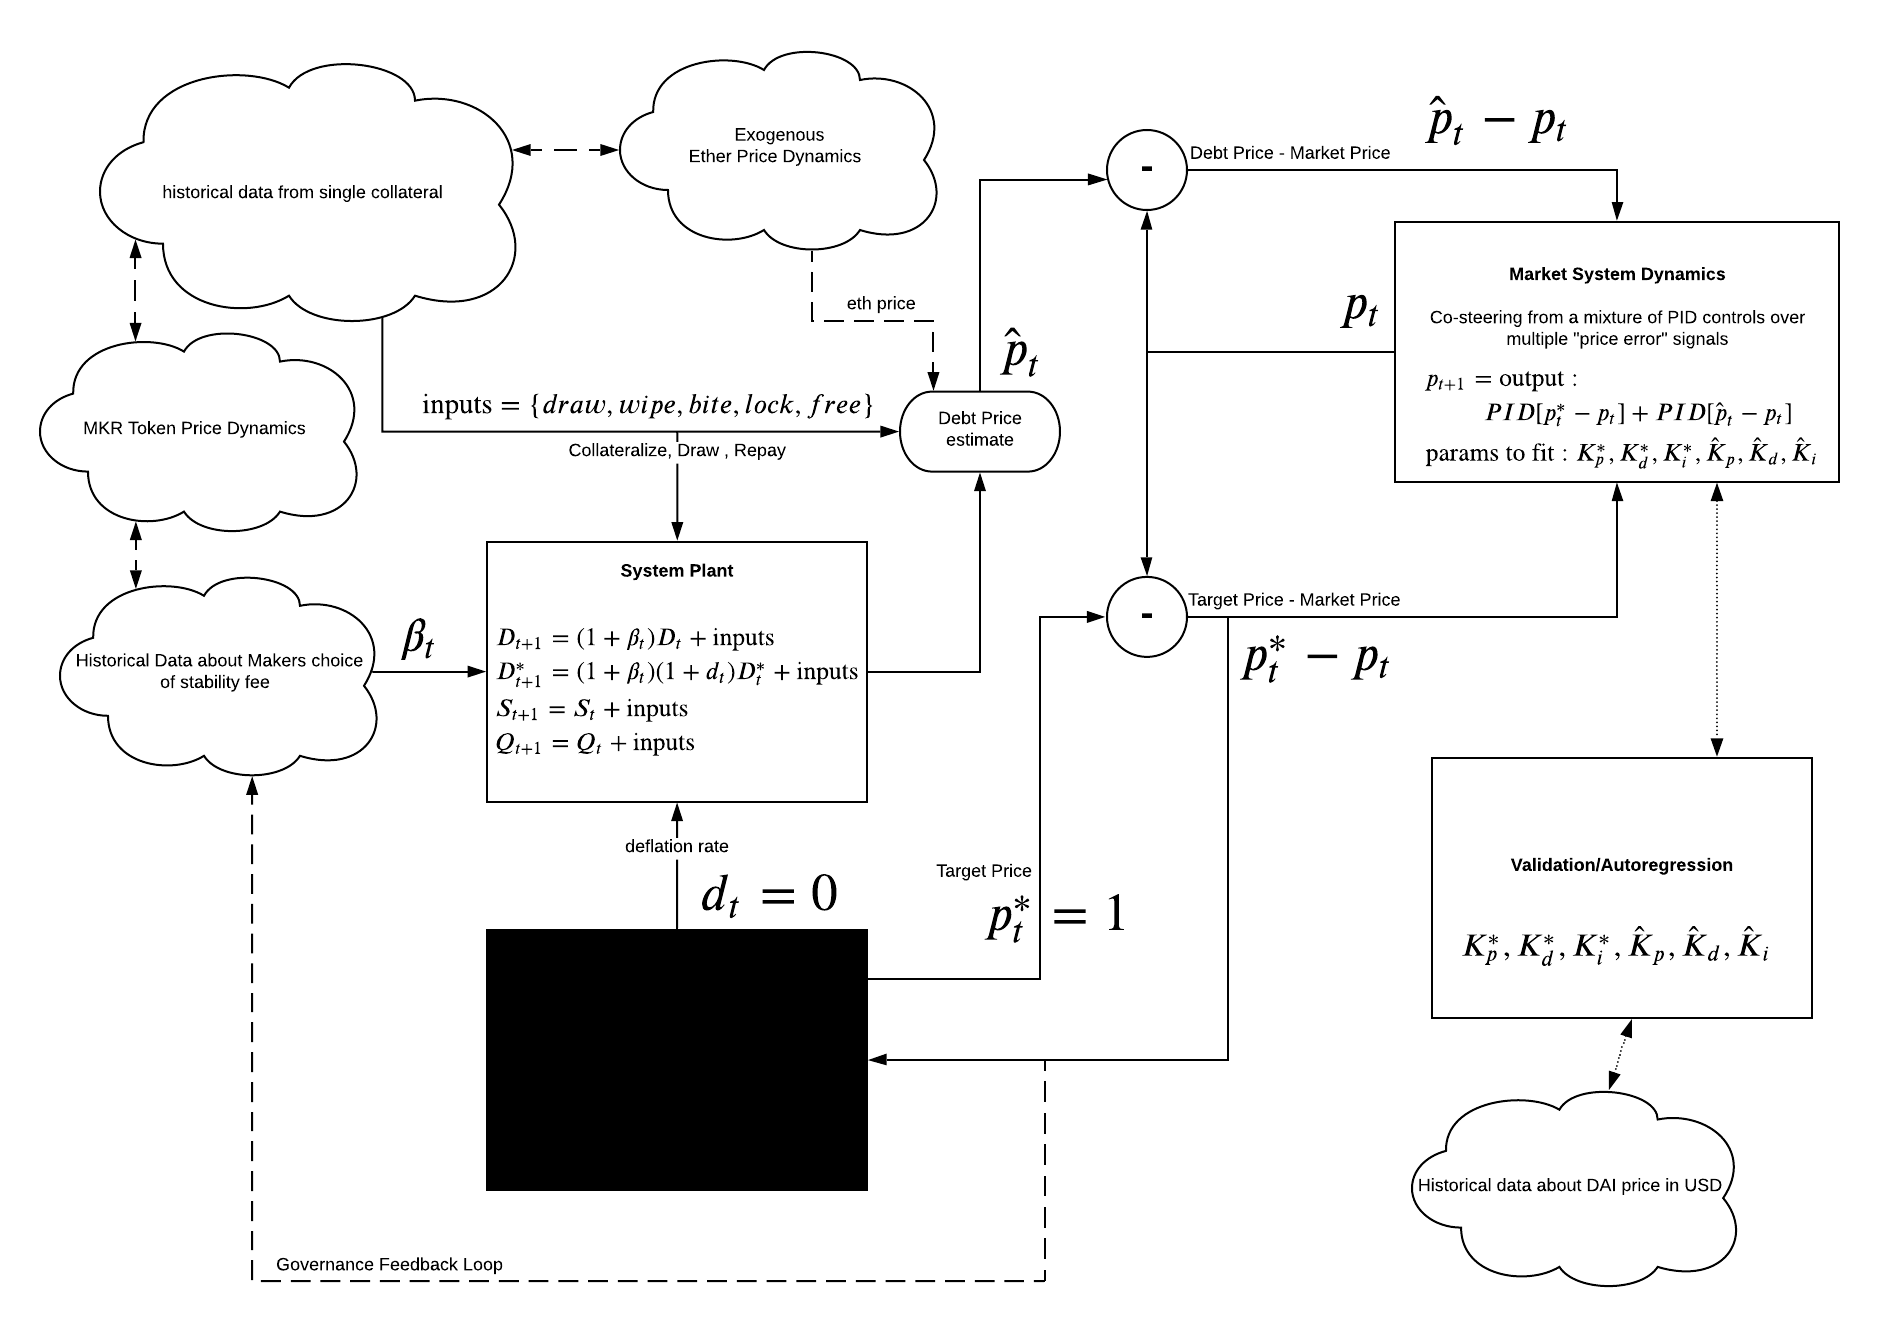

In [1]:
from IPython.display import Image
Image(filename="images/dai_data_autoregression.png")

Ultimately, the goal is to plug the market model into a RAI system model in which a PI controller acts on the redemption rate (Maker's original design's "deflation rate" or "target rate") $d_t$ in an attempt to correct the error between the redemption price (Maker's "target price") and the market price of RAI, and tune the parameters of the PI controller.

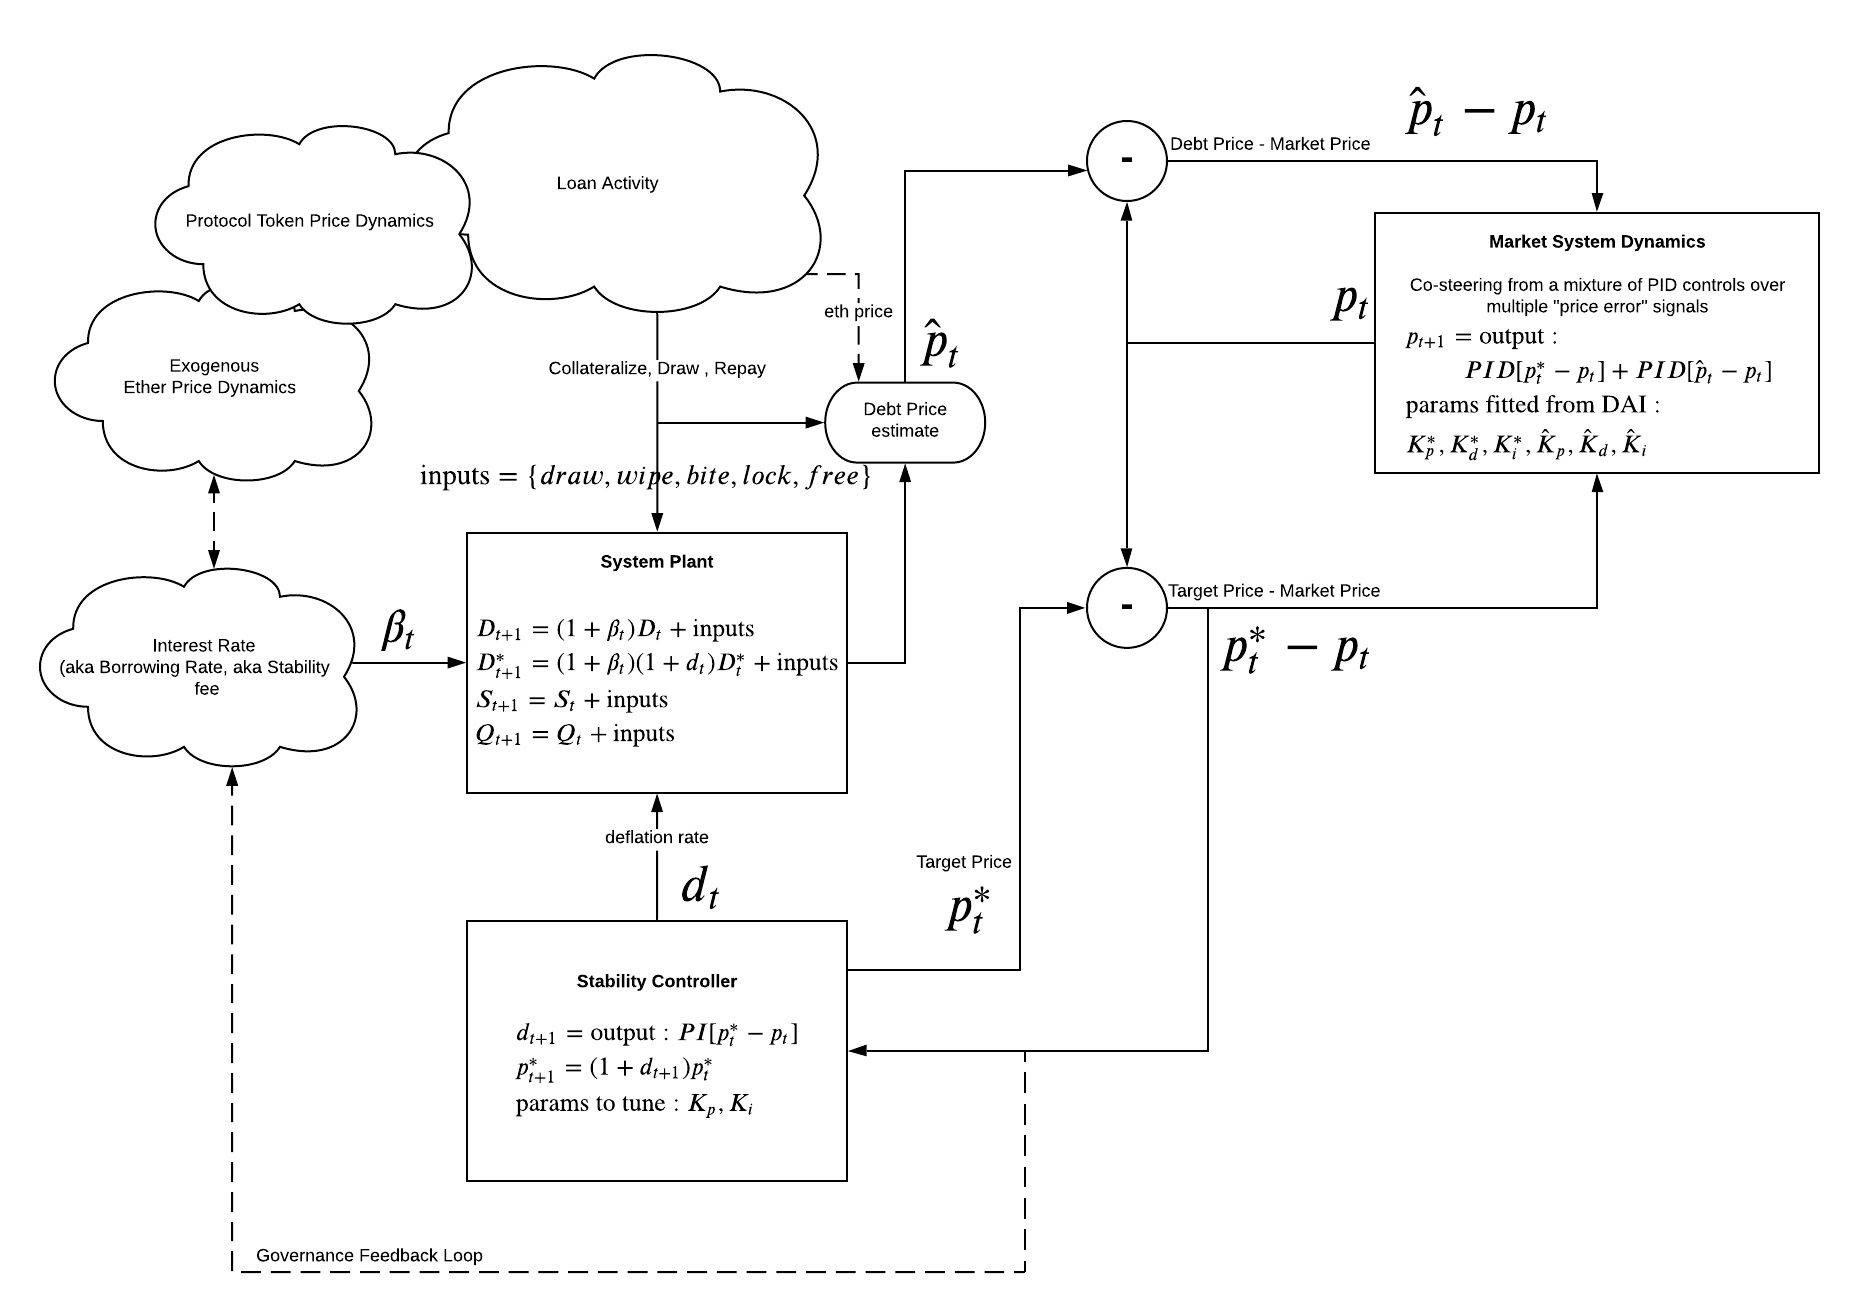

In [2]:
Image(filename="images/rai_laws_of_motion.png")

In order to collect activity data on the debt system of Maker, we need to clearly define its components and mechanisms and evaluate what information is available. In essence, a debt system can be defined by the following  equation:

$D_{t+\Delta{t}} = (1+\beta_t)^{\Delta{t}}\cdot{D_t} + u_{1;t+\Delta{t}} - \epsilon_{2;t+\Delta{t}}$, where:
* $D_t$ is the total debt at time $t$, denominated in whatever unit the parts agree on (SAI in the case of Maker)
* $\beta_t$ is the interest rate per unit of time (Maker's sability fee)
* $u_{1;t+\Delta{t}}$ is the amount of debt corresponding to new loans made at time $t+\Delta{t}$
* $\epsilon_{2;t+\Delta{t}}$ is the amount of debt repaid at time $t+\Delta{t}$

In Maker's and RAI's case, this definition needs to be further refined because:
* new debt $u_1$ causes new tokens (SAI or RAI) to be minted; 
* repayments $\epsilon_2$ are split between tokens (SAI or RAI) being burned and some value being transferred to protocol token holders.

Let:  
$D_t = D_{1;t} + D_{2;t}$, where:
* $D_t$ is the debt
* $D_{1;t}$ is the principal
* $D_{2;t}$ is the interest

Let's further define  
$\epsilon_{2;t} = u_{2;t} + w_{2;t}$, where
* $\epsilon_{2;t}$ is the debt repaid at time $t$
* $u_{2;t}$ is the part of $\tilde{u}_t$ that corresponds to repayment of the principal debt (tokens burned)
* $w_{2;t}$ is the part of $\tilde{u}_t$ that corresponds to value flow to protocol token holders

Substitute the definitions in the original debt equation:  
$D_{t+\Delta{t}} = (1+\beta_t)^{\Delta{t}}\cdot{D_t} + u_{1;t+\Delta{t}} - \epsilon_{2;t+\Delta{t}}$  
$D_{1;t+\Delta{t}} + D_{2;t+\Delta{t}} = (1+\beta_t)^{\Delta{t}}\cdot({D_{1;t} + D_{2;t}}) + u_{1;t+\Delta{t}} - u_{2;t+\Delta{t}} - w_{2;t+\Delta{t}}$  
* $D_{1;t+\Delta{t}} = D_{1;t} + u_{1;t+\Delta{t}} - u_{2;t+\Delta{t}}$  
* $D_{2;t+\Delta{t}} = (1+\beta_t)^{\Delta{t}}\cdot({D_{1;t} + D_{2;t}}) - D_{1;t} - w_{2;t+\Delta{t}} $
    * $D_{2;t+\Delta{t}} = D_{2;t} + [(1+\beta_t)^{\Delta{t}}-1]\cdot({D_{1;t} + D_{2;t}}) - w_{2;t+\Delta{t}}$

Maker's implementation of these dynamics is quite more complex (index i denotes specific CDP):
* Governance controlled parameters
    * tax ($\tau$): was always constant at 1
    * fee ($\beta$): varied over the lifetime of single collateral DAI 
* Continuous dynamics between events
    * rhi ($\rho$): $\rho_{t+\Delta{t}} = \rho_t \cdot \beta^{\Delta{t}}$
    * chi ($\chi$): $\chi_{t+\Delta{t}} = \chi_t \cdot \tau^{\Delta{t}}$
        * Because tax was constant at 1, $\chi_{t} = \chi_0 = 1 \forall t$
* art : $a[i]$
    * Draw $u_1$: $a[i]_{k+1} = a[i]_k + \frac{u_1}{\chi_{k+1}}$
    * Wipe $u_2$: $a[i]_{k+1} = a[i]_k - \frac{u_2}{\chi_{k+1}}$
    * Bite: $a[i]_{k+1} = 0$
* tab: $\text{tab}[i] = a[i] \cdot \chi$ 
* ire: $b[i]$
    * Draw $u_1$: $b[i]_{k+1} = b[i]_k + \frac{u_1}{\rho_{k+1}}$
    * Wipe $u_2$: 
        * $b[i]_{k+1} = b[i]_k - \frac{u_2 + u_2\frac{\text{rap}[i]}{\text{tab}[i]}}{\rho_{k+1}}$
        * $b[i]_{k+1} = b[i]_k - u_2 \frac{1 + \frac{b[i] \cdot \rho - a[i] \cdot \chi}{a[i] \cdot \chi}}{\rho_{k+1}}$
        * $b[i]_{k+1} = b[i]_k - u_2 \frac{1 + \frac{b[i] \cdot \rho - a[i] \cdot \chi}{a[i] \cdot \chi}}{\rho_{k+1}}$
    * Bite: $b[i]_{k+1} = 0$
* rap: $\text{rap}[i] = b[i] \cdot \rho - a[i] \cdot \chi$
* rum: $D_1 = \sum{a[i]}$
    * Draw $u_1$: $D_{1;k+1} = D_{1;k} + \frac{u_1}{\chi_{k+1}}$
    * Wipe $u_2$: $D_{1;k+1} = D_{1;k} - \frac{u_2}{\chi_{k+1}}$
    * Bite: $D_{1;k+1} = D_{1;k} - a[i]_{k}$
* SAI supply ($S$)
    * Draw $u_1$: $S_{k+1} = S_k + u_1$
    * Wipe $u_2$: $S_{k+1} = S_k - u_2$

The complete system can be represented as a stocks and flows diagram  

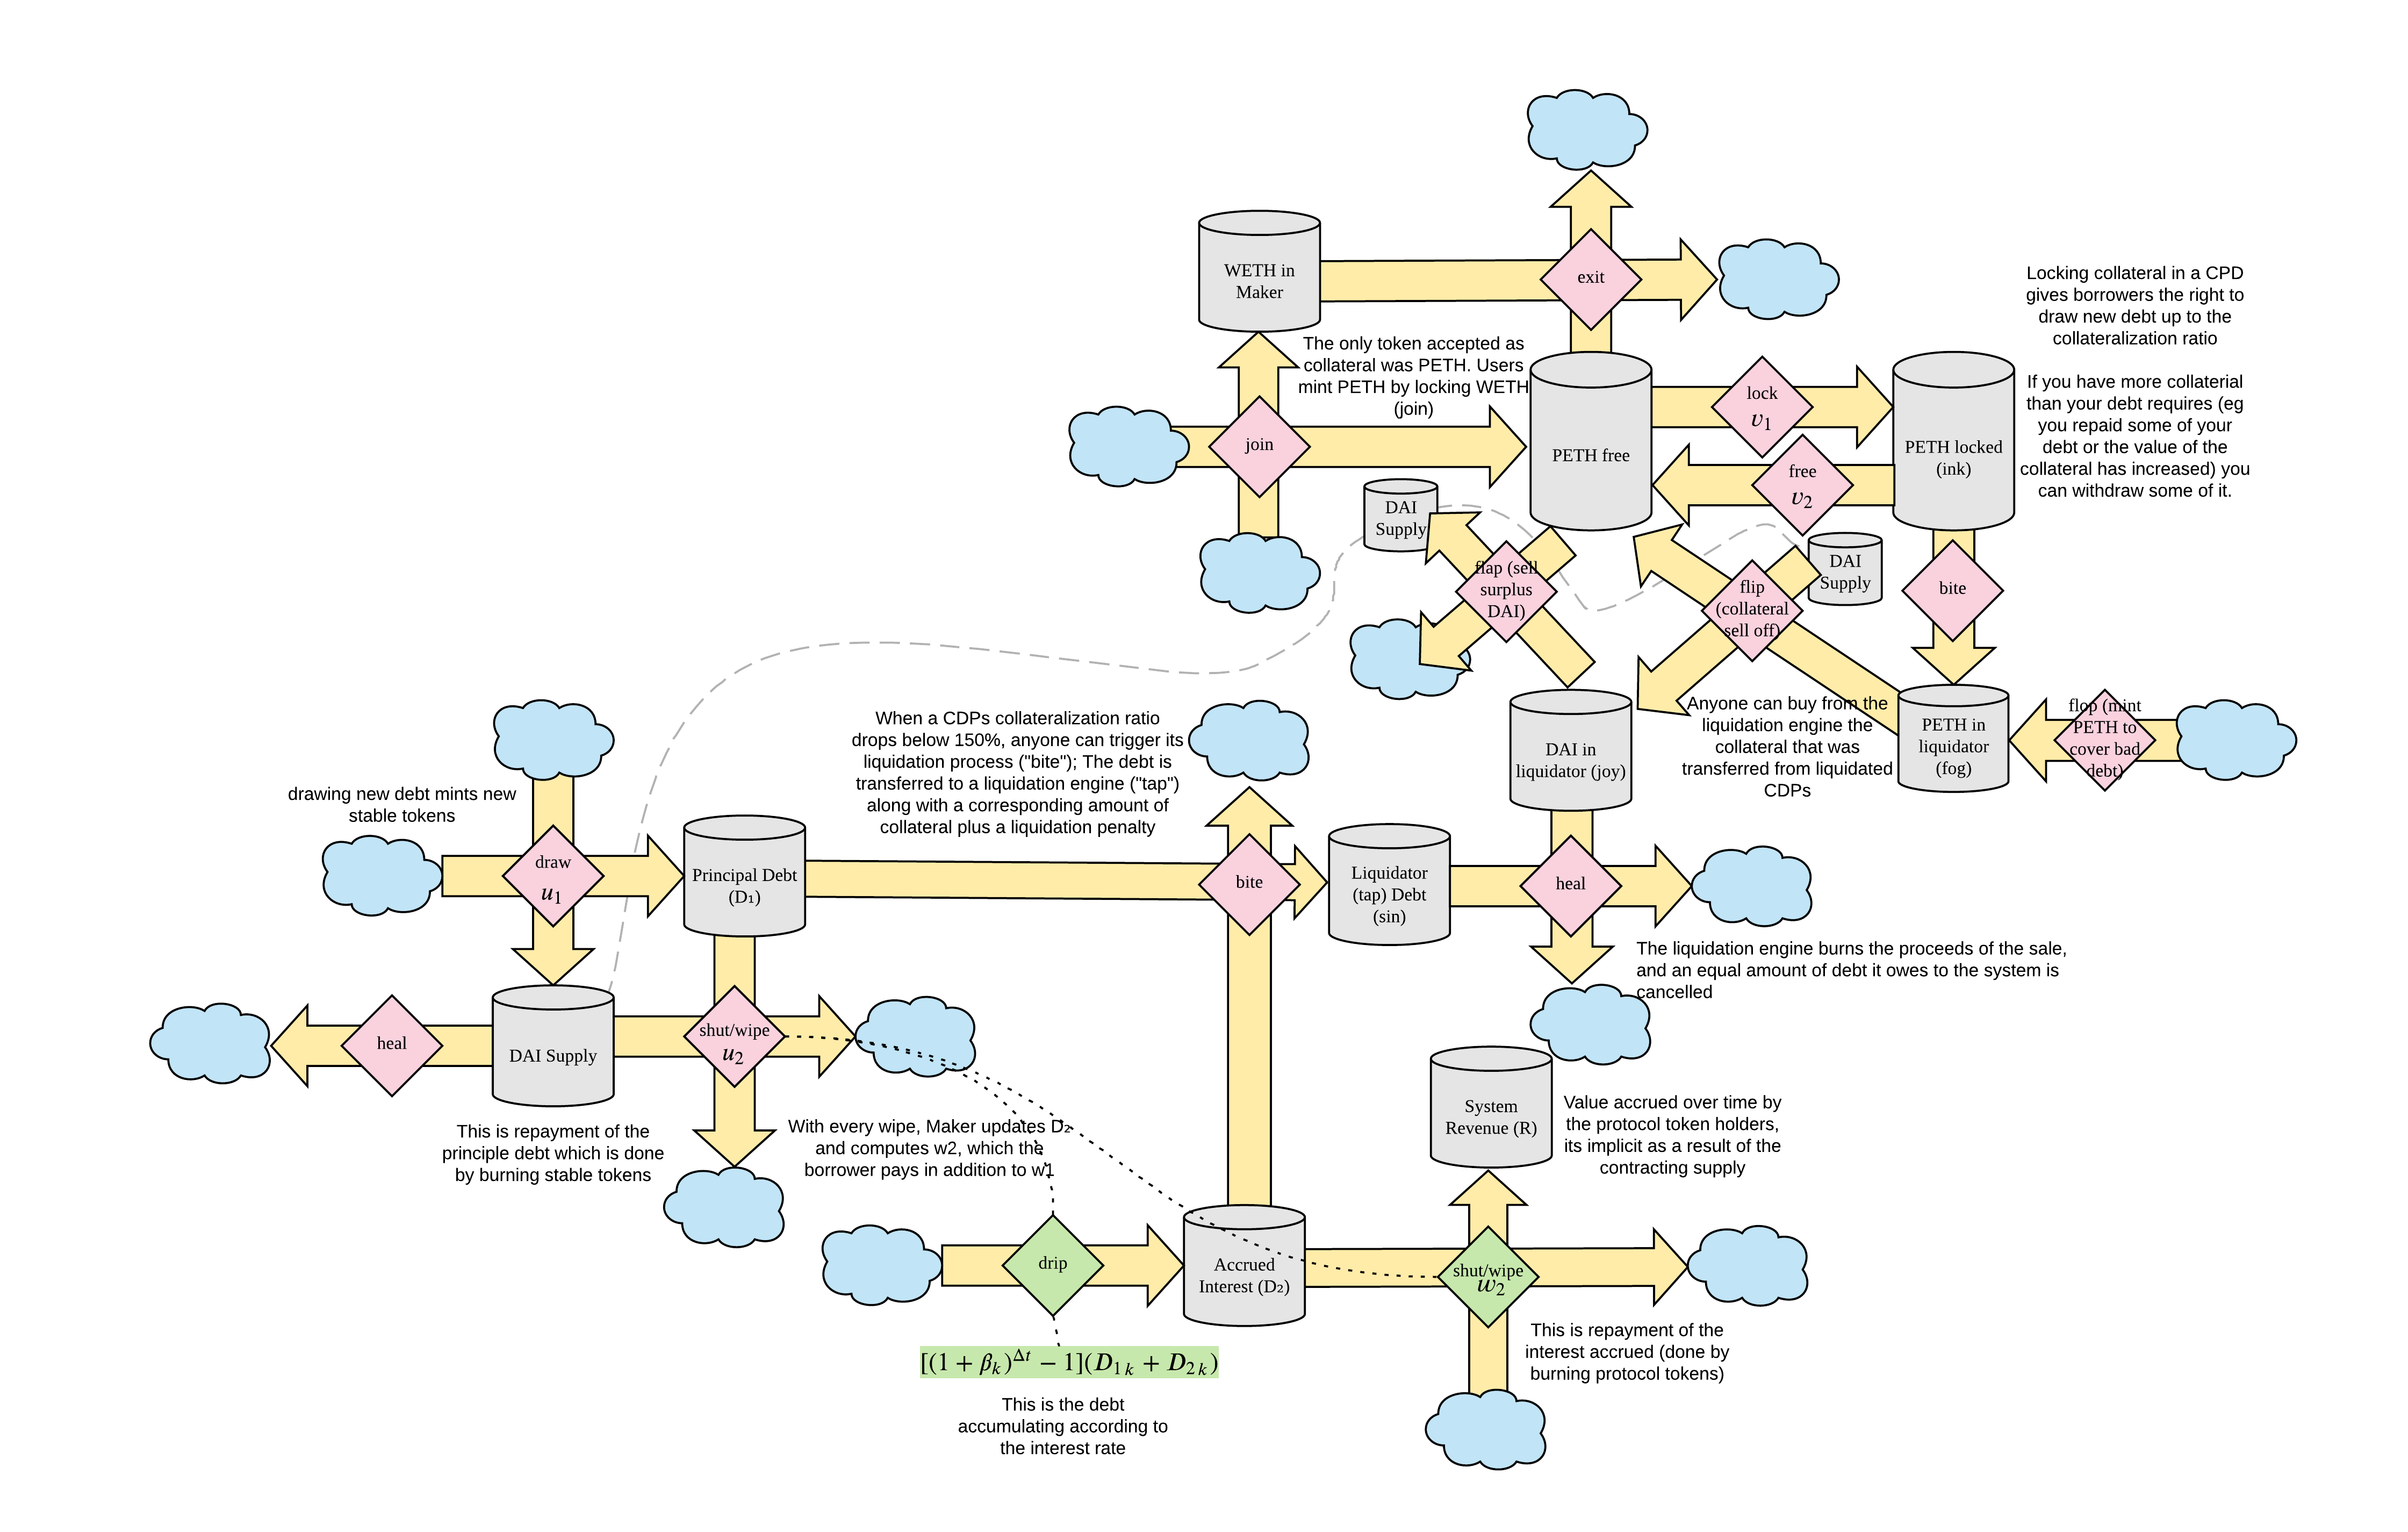

In [3]:
Image(filename="images/SCD_stocks_and_flows.png")

We highlight that in this model of the system some concepts are not defined in the exact same way as the Maker implementation. Notably, Maker does not directly keep track of $D_2$. Instead, when a repayment occurs the borrower defines $u_2$ and the system computes a corresponding $w_2$ to be paid in addition to that (the medium of exchange for $w_2$ is MKR tokens)
* Wipe $u_2$
    * Compute _owe_: $w_2$
        * $w_2 = u_2\frac{\text{rap}[i]}{\text{tab}[i]}$
        * $w_2 = u_2\frac{b[i] \cdot \rho - a[i] \cdot \chi}{a[i] \cdot \chi}$
    * Borrower must pay the equivalent of $w_2$ in MKR tokens

Equally important is the fact that when a CDP is liquidated, the component of its debt corresponding to interest accrued is effectively "waived" - no value flows to MKR token holders. On the other hand, a liquidation penalty $\lambda$ is imposed on the liquidated CDP, and an amount of collateral equivalent to $(1+\lambda)a[i]$ is put for sale in order to recover $a[i]$ in SAI.

In this model we'll use `days` as the unit of time. This will make the data collection process easier because there are many different sources from which to pull daily aggregated data. We assume loss of precision will be minor.

For the purposes of this model, we can safely ignore some parts of the system represented in the stocks and flows diagram above. We are particularly interested in the amount of collateral and the total debt and its components $D_1$ and $D_2$, as well as their corresponding flows. The [Bloxy Maker DAO dashboard](https://stat.bloxy.info/superset/dashboard/makerdao) provides access to CSV files containing some of those pieces of information:
1. Daily total WETH locked in Maker, deposits and withdrawals
2. Daily supply of SAI, mints and burns

If we assume that the liquidation process of all CDPs finalize on the same day they are triggered, we can work with a simplified version of the previous stocks and flows diagram:

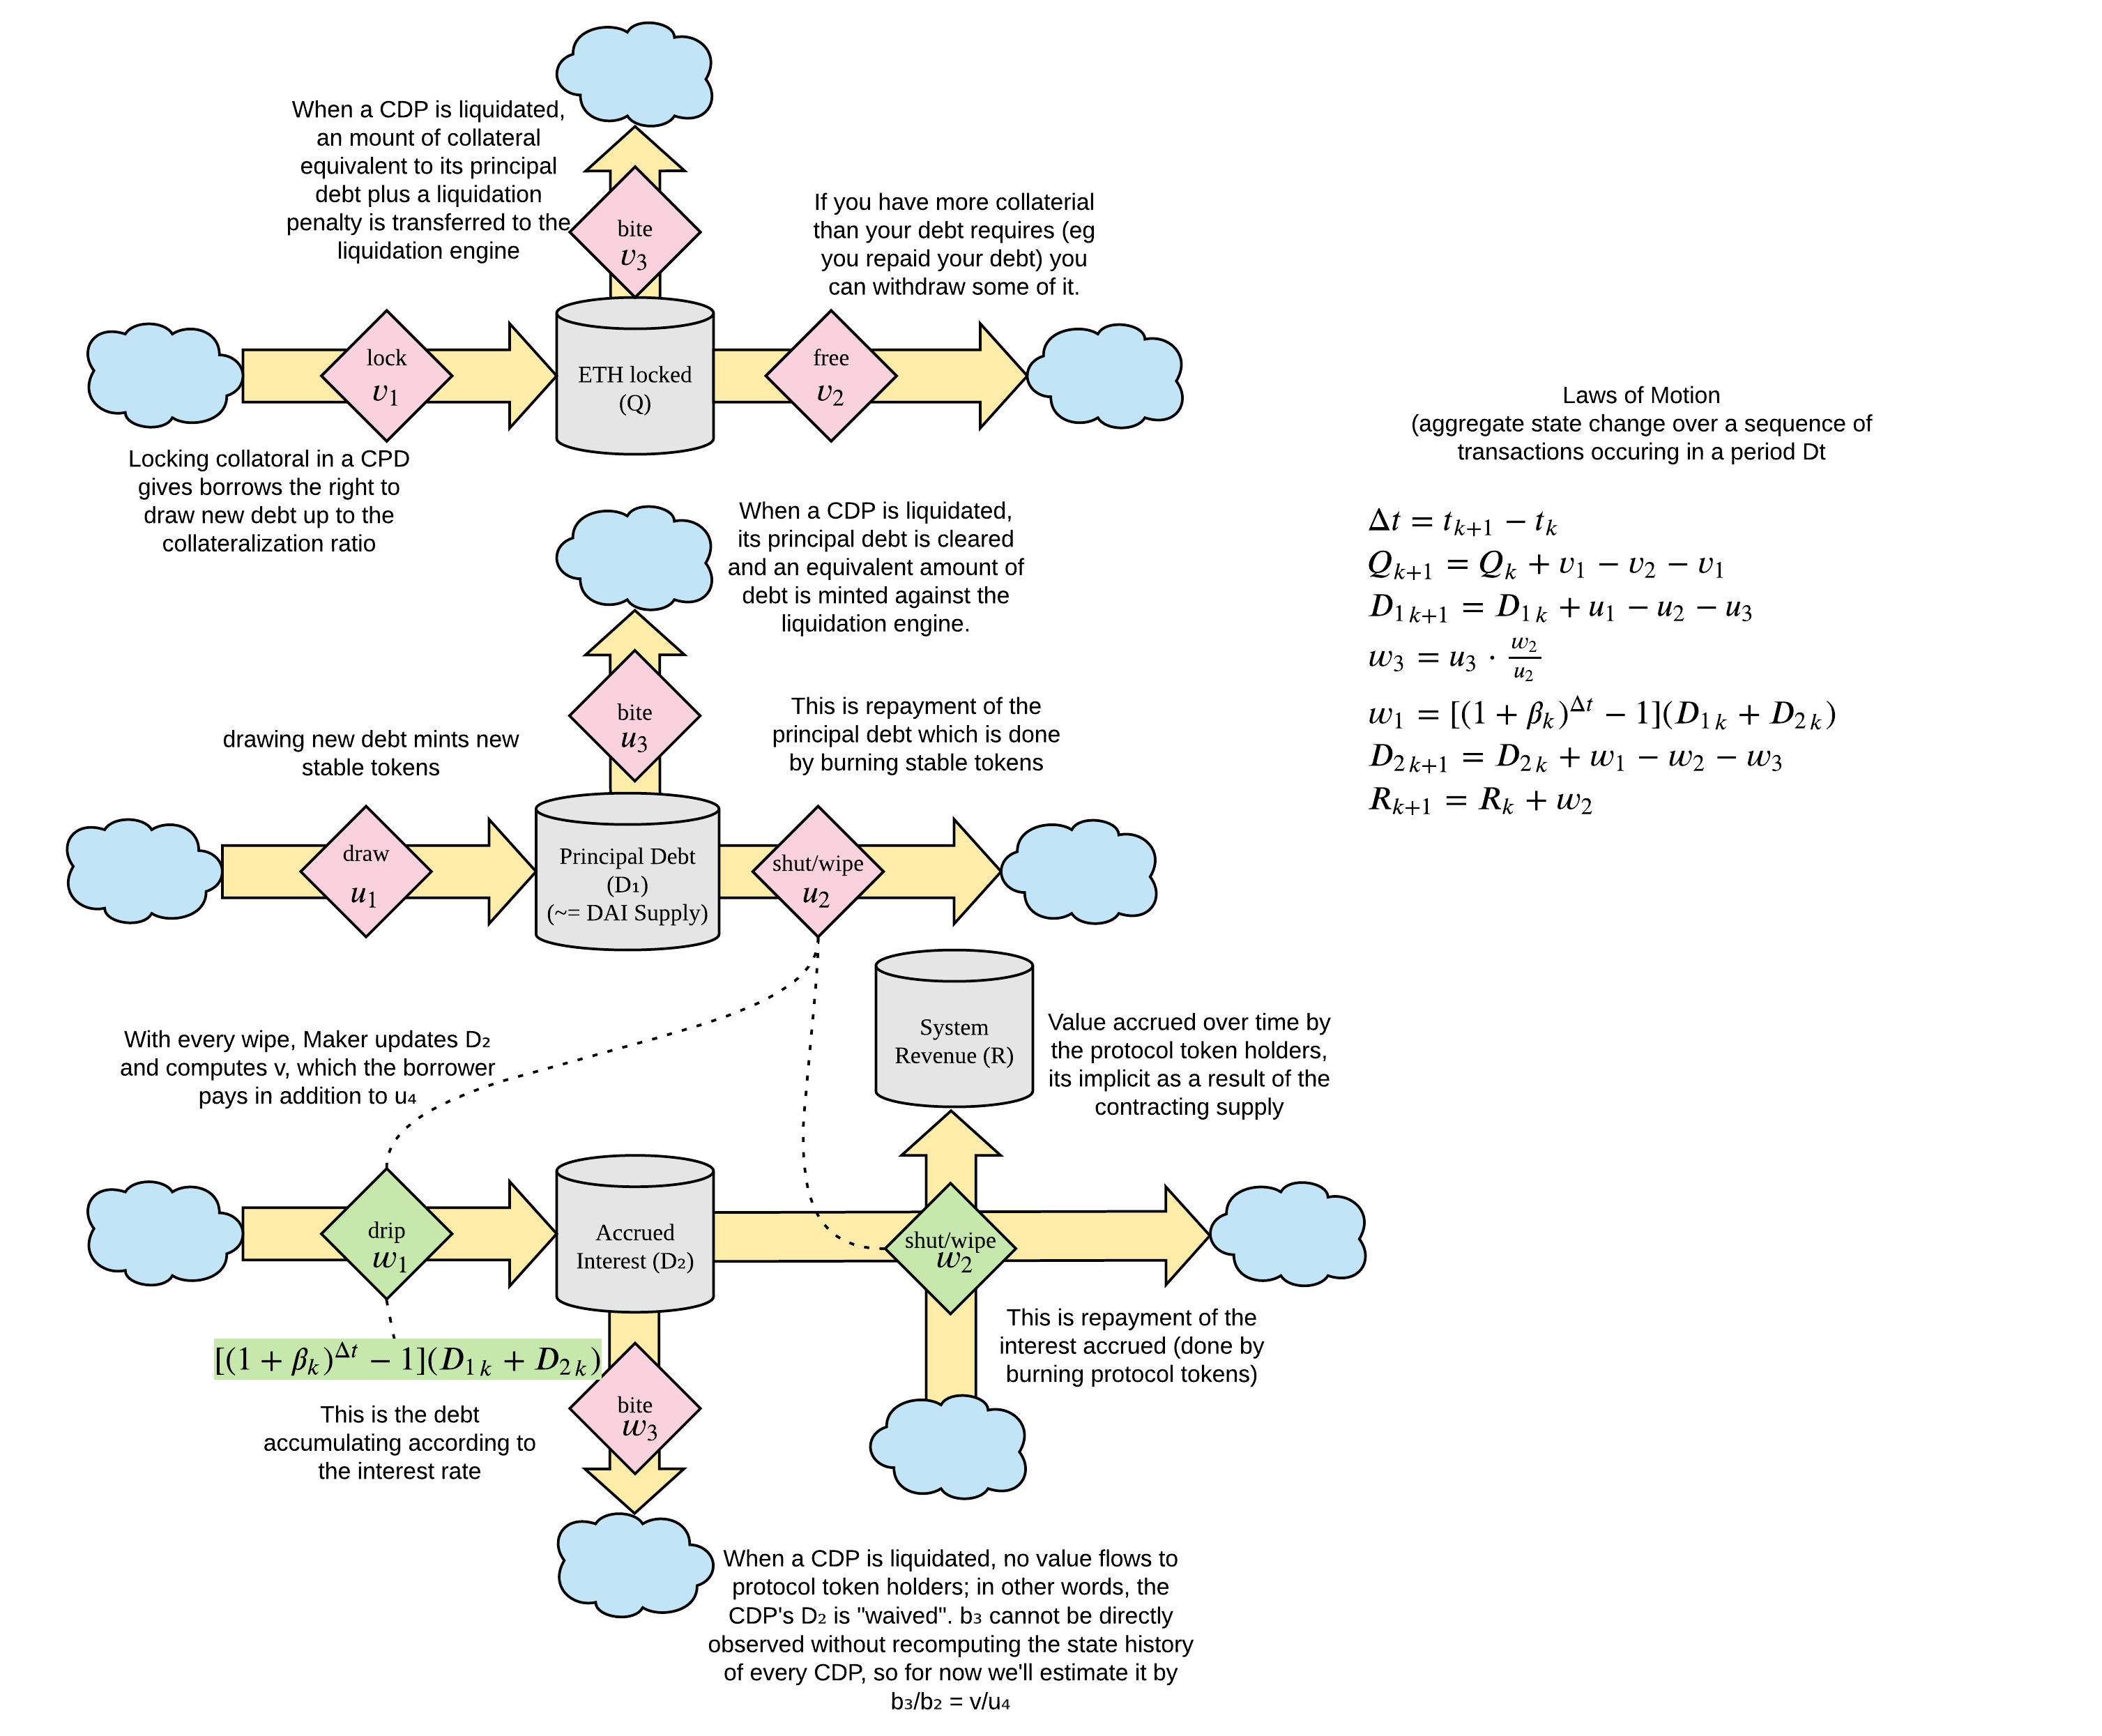

In [4]:
Image(filename="images/SCD_simplified.png")

Under the previous assumption, the Bloxy data provides us with direct access to:
* $Q$: WETH locked
* $v_1$: WETH deposited
* $v_2+v_3$: WETH withdrawn
* $S \tilde{=} D_1$: SAI supply
* $u_1$: SAI minted
* $u_2+u_3$: SAI burned

$w_1$ is simply defined as the daily interest accrued and can be directly computed from $D_1$, $D_2$ and $\beta_t$
* $w_1 = [(1+\beta_t)^{1/365}-1]\cdot({D_{1;t} + D_{2;t}})$

In order to compute $w_2$, we queried Dune Analytics for transfers of MKR to the burning smart contract (`pit`) along with the price of MKR informed by the MKR price oracle and the amount of SAI burned ($u_2$) within the same transaction. So from the Dune query we have:
* $w_2$: interest paid to MKR token holders
* $u_2$: principal paid with wipes/shuts of CDPs

We can thus compute $u_3$
* $u_3 = u_2 + u_3 - u_2$

Because $w_3$ cannot be directly observed nor precisely computed unless we reconstruct the entire history of each individual CDP, we estimate it as 
* $w_3 = u_3 \cdot \frac{w_2}{u_2}$

And with this we have all the information we need to compute $D_2$
* $D_{2;t+1} = D_{2;t} + w_1 - w_2 - w_3$

In [5]:
import pandas as pd

# read Bloxy data on ETH locked in Maker, rename columns to match our equations
bloxy_eth_df = pd.read_csv('data/raw_files/dai_weth.csv')
bloxy_eth_df.set_index(pd.to_datetime(bloxy_eth_df['__timestamp']).dt.date, 
                    verify_integrity=True,
                    inplace=True,
                   )
bloxy_eth_df.sort_index(inplace=True)
original_columns = list(bloxy_eth_df.columns)
bloxy_eth_df['Q'] = bloxy_eth_df['Locked Amount']
bloxy_eth_df['v_1'] = bloxy_eth_df['Accumulated Lock'].diff().fillna(bloxy_eth_df['Accumulated Lock'])
bloxy_eth_df['v_2 + v_3'] = bloxy_eth_df['Accumulated Free'].diff().fillna(bloxy_eth_df['Accumulated Free'])
bloxy_eth_df.drop(columns=original_columns, inplace=True)

# read Bloxy data on SAI supply, rename columns to match our equations
bloxy_sai_df = pd.read_csv('data/raw_files/dai_minted_burnt.csv')
bloxy_sai_df.set_index(pd.to_datetime(bloxy_sai_df['__timestamp']).dt.date, 
                    verify_integrity=True,
                    inplace=True,
                   )
bloxy_sai_df.sort_index(inplace=True)
original_columns = list(bloxy_sai_df.columns)
bloxy_sai_df['u_1'] = bloxy_sai_df['Minted DAI'].diff().fillna(bloxy_sai_df['Minted DAI'])
bloxy_sai_df['u_2 + u_3'] = bloxy_sai_df['Burnt DAI'].diff().fillna(bloxy_sai_df['Burnt DAI'])
bloxy_sai_df.drop(columns=original_columns, inplace=True)

# read Dune query for CDPs wipes/shuts, rename columns to match our equations
dune_df = pd.read_json('data/raw_files/dune_data.json')
dune_df.set_index(pd.to_datetime(dune_df['date_trunc']).dt.date, 
                          verify_integrity=True,
                          inplace=True                          
                         )
original_columns = list(dune_df.columns)
dune_df['u_2'] = dune_df['debt_payment']
dune_df['w_2'] = dune_df['usd_fee_paid']
dune_df.drop(columns=original_columns, inplace=True)

# read CSV provided by the client, rename columns to match our equations
reflexer_df = pd.read_csv('data/raw_files/DAIETH_data.csv', usecols=['date','ETH Price', 'Stability Fee', 'DAI Price'])
reflexer_df.set_index(pd.to_datetime(reflexer_df['date']).dt.date, 
                    verify_integrity=True,
                    inplace=True,
                   )
reflexer_df.sort_index(inplace=True)
original_columns = list(reflexer_df.columns)
reflexer_df['rho_star'] = reflexer_df['ETH Price']
reflexer_df['beta'] = reflexer_df['Stability Fee']/100
reflexer_df['p'] = reflexer_df['DAI Price']
reflexer_df.drop(columns=original_columns, inplace=True)

# join the dataframes
debt_market_df = reflexer_df.join(bloxy_eth_df).join(bloxy_sai_df).join(dune_df)

# fill with 0 for days where the Dune query didn't return any wipes/shuts
debt_market_df['u_2'].fillna(0, inplace=True)
debt_market_df['w_2'].fillna(0, inplace=True)

# compute u_3 
debt_market_df['u_3'] = debt_market_df['u_2 + u_3'] - debt_market_df['u_2']

# on 7 days, u_2 > u_2 + u_3 by a small amount
# debt_market_df[debt_market_df['u_2 + u_3']/debt_market_df['u_2']<0.999999]

# This is probably due to us using data from different sources
# We could build a Dune query to replace the Bloxy CSV, 
# but for now the error seems small enough that we can ignore it
debt_market_df['u_3'] = debt_market_df['u_3'].apply(lambda x: max(0,x))
debt_market_df['u_2 + u_3'] = debt_market_df['u_2'] + debt_market_df['u_3']

# estimate w_3 based on u_3, w_2 and u_2
debt_market_df['w_3'] = debt_market_df['u_3'] * debt_market_df['w_2'] / debt_market_df['u_2']
debt_market_df['w_3'].fillna(0, inplace=True)
debt_market_df['w_2 + w_3'] = debt_market_df['w_2'] + debt_market_df['w_3']

# compute D_1
debt_market_df['D_1'] = debt_market_df['u_1'].cumsum() - debt_market_df['u_2'].cumsum() - debt_market_df['u_3'].cumsum()

# iteratively compute w_1 and D_2
import numpy as np
d2 = [0]
w1 = [0]
for i,r in debt_market_df.iterrows():
    if i==debt_market_df.index[0]:
        continue
    beta = r['beta']
    delta_t = 1/365
    d_1 = r['D_1']
    d_2 = d2[-1]
    w_2 = r['w_2']
    w_3 = r['w_3']
    new_w1 = ((1+beta)**delta_t - 1) * (d_1 + d_2)
    new_d2 = d_2 + new_w1 - w_2 - w_3
    w1.append(new_w1)
    d2.append(new_d2)
debt_market_df['D_2'] = d2
debt_market_df['w_1'] = w1

# compute D and C^star; p^star for Maker is fixed at 1
debt_market_df['D'] = debt_market_df['D_1'] + debt_market_df['D_2']
debt_market_df['C_star'] = debt_market_df['Q'] * debt_market_df['rho_star']
debt_market_df['p_star'] = 1

# compute the exponential moving average (10 days) of the price of SAI
def ExpMovingAverage(values, window):
    weights = np.exp(np.linspace(-1., 0., window))
    weights /= weights.sum()
    a =  np.convolve(values, weights, mode='full')[:len(values)]
    a[:window] = a[window]
    return a
debt_market_df['p_ema_10'] = pd.Series(ExpMovingAverage(debt_market_df['p'], 10), index=debt_market_df.index)

debt_market_df.to_csv('data/debt_market_df.csv')

## Plots
We plot some of the data to visually inspect the results of the ETL process

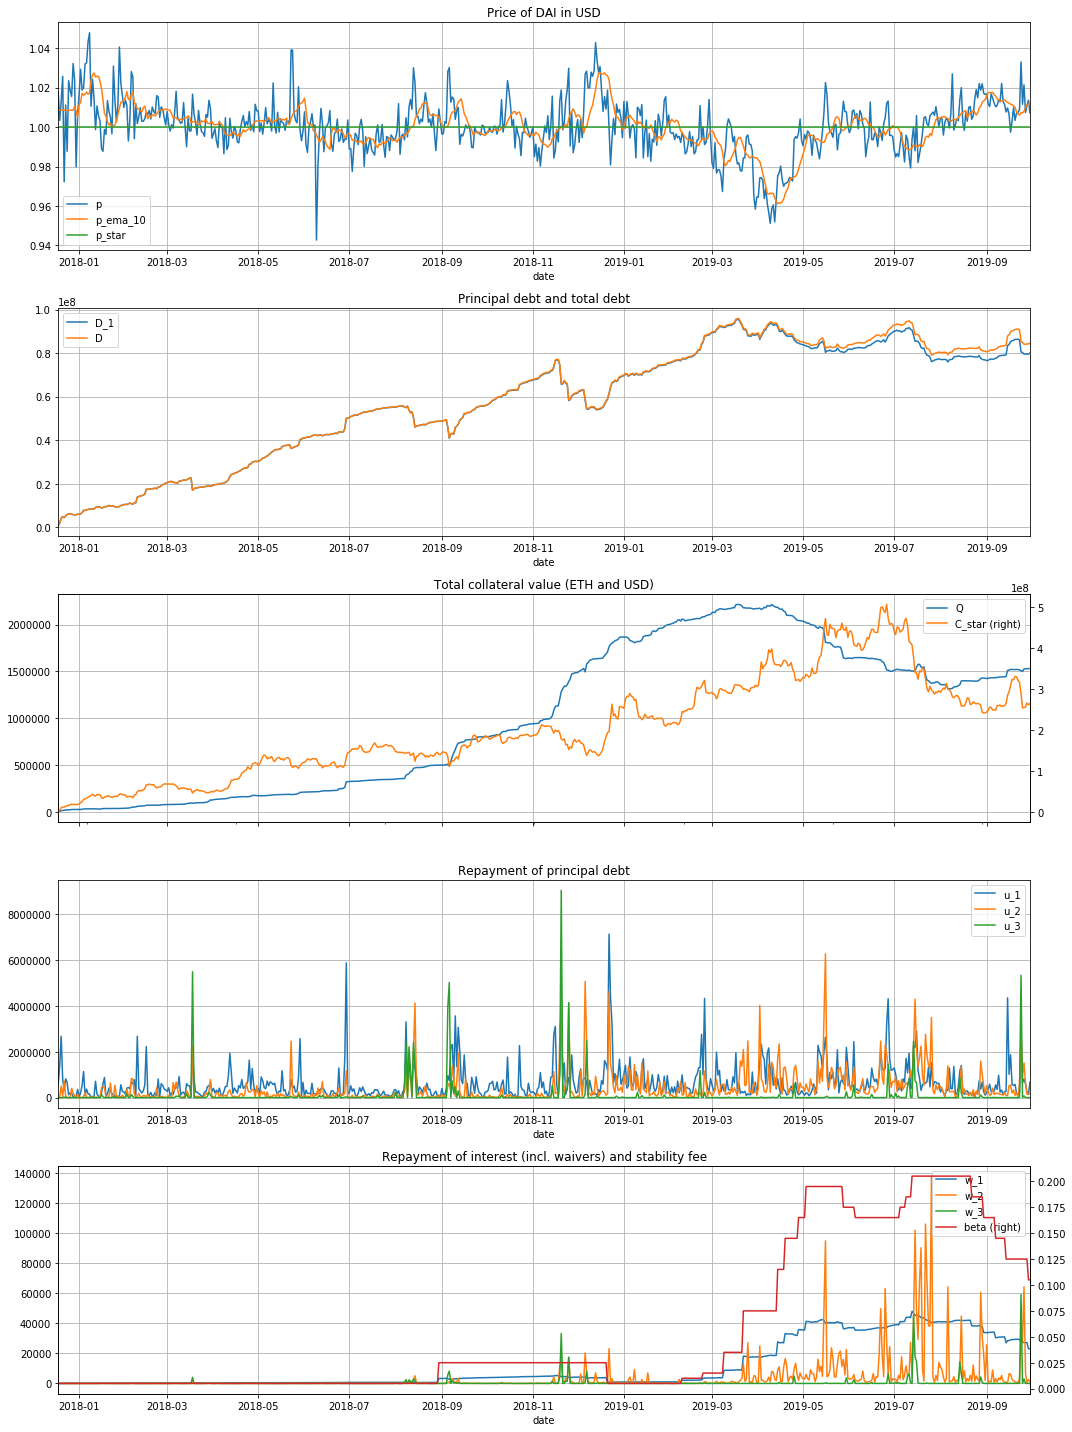

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(5, 1, figsize=(15,20))

debt_market_df.plot(y=['p', 'p_ema_10', 'p_star'], ax=axs[0], grid=True, title='Price of DAI in USD')
debt_market_df.plot(y=['D_1','D'], ax=axs[1], grid=True, title='Principal debt and total debt')
debt_market_df.plot(y=['Q'], ax=axs[2], grid=True, title='Total collateral value (ETH and USD)')
debt_market_df.plot(y=['C_star'], secondary_y=True, ax=axs[2], grid=True)
debt_market_df.plot(y=['u_1', 'u_2', 'u_3'], ax=axs[3], grid=True, title='Repayment of principal debt')
debt_market_df.plot(y=['w_1', 'w_2', 'w_3'], ax=axs[4], grid=True, title='Repayment of interest (incl. waivers) and stability fee')
debt_market_df.plot(y=['beta'], secondary_y=True, ax=axs[4], grid=True)
plt.tight_layout()

## Debt Price Model
With the data in hand, we can move on to the next step and create a model for the debt price. Several different heuristics and automated machine learning models were experimented with. Details of those approaches can be found in [Appendix I](appendix_i_debt_price_heuristics.ipynb) and [Appendix II](appendix_ii_debt_price_ML.ipynb). Ultimately, the debt price was modelled using an ensemble of regressors having the 10-days exponential moving average of the market price as the target and 17 features of the debt market as the regression variables.  
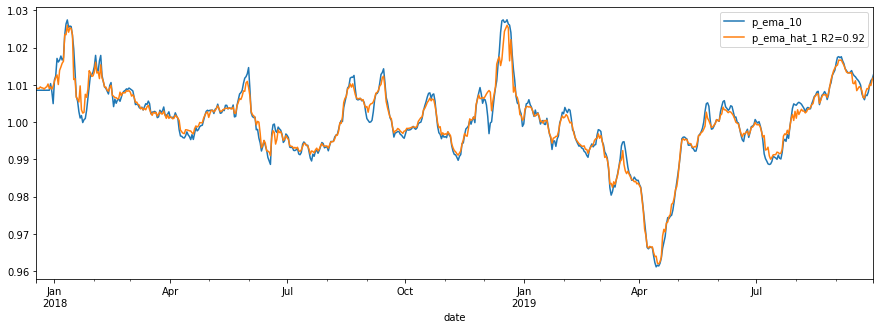

## Market Price Model
Finally, a linear regression model is fitted to create an estimator of the market price. We model the market price as a combination of an autoregressive model and two PID controllers responding to the error between the market price and the target price and the error between the market price and the target price:  

$\hat{e}_t = \hat{p}_t-p_t$  
$e^*_t = p^*_t-p_t$  
$p_{t+1} = K_0 + Kp_t + \hat{K}_p\hat{e}_t + \hat{K}_i\sum\limits_{\tau=0}^t\hat{e}_\tau + \hat{K}_d(\hat{e}_t-\hat{e}_{t-1}) + K^*_pe^*_t + K^*_i\sum\limits_{\tau=0}^te^*_\tau + K^*_d(e^*_t-e^*_{t-1})$

The eight parameters of the linear model were estimated using the ordinary least squares (OLS) method. Further details can be found in [Appendix III](appendix_iii_market_price_regression.ipynb).

In [7]:
%%capture
import pandas as pd
from IPython.display import HTML, display
import tabulate

debt_market_df = pd.read_csv('data/debt_market_df.csv', index_col='date', parse_dates=True)

# Load debt price model
import pickle
loaded_model = pickle.load(open('debt_price_estimator.pickle', 'rb'))

# Compute debt price from historical Maker data
features = ['beta', 'Q', 'v_1', 'v_2 + v_3', 
            'rho_star', 'C_star',
            'D_1', 'u_1', 'u_2', 'u_3', 'u_2 + u_3', 
            'D_2', 'w_1', 'w_2', 'w_3', 'w_2 + w_3',
            'D']
data_to_predict = debt_market_df[features]
loaded_model_predictions = loaded_model.predict(data_to_predict)

# Prepare market price model dataset
df = debt_market_df[['p', 'p_star']].copy()
df['p_hat'] = loaded_model_predictions
df['e_hat'] = df['p_hat'] - df['p']
df['e_star'] = df['p_star'] - df['p']
df['cumsum_e_hat'] = df['e_hat'].cumsum()
df['cumsum_e_star'] = df['e_star'].cumsum()
df['delta_e_hat'] = df['e_hat'].diff().fillna(df['e_hat'])
df['delta_e_star'] = df['e_star'].diff().fillna(df['e_star'])
# Define target variable as the market price on the next day
df['y'] = df['p'].shift(-1)
df.dropna(inplace=True)

# fit the model
import statsmodels.api as sm
input_vars = ['p', 
                'e_hat', 'e_star', 
                'cumsum_e_hat', 'cumsum_e_star', 
                'delta_e_hat', 'delta_e_star']
input_data = df[input_vars]
input_data = sm.add_constant(input_data)

output_var = ['y']
output_data = df[output_var]

ols_model = sm.OLS(output_data, input_data)
results = ols_model.fit()

In [8]:
# display estimated parameters
mapping = {
    '$K_0$': 'const',
    '$K$': 'p',
    '$\hat{K}_p$': 'e_hat',
    '$\hat{K}_i$': 'cumsum_e_hat',
    '$\hat{K}_d$': 'delta_e_hat',
    '$K^*_p$': 'e_star',
    '$K^*_i$': 'cumsum_e_star',
    '$K^*_d$': 'delta_e_star'
}
table = [[k for k in mapping.keys()], [round(results.params[v],4) for v in mapping.values()]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

$K_0$,$K$,$\hat{K}_p$,$\hat{K}_i$,$\hat{K}_d$,$K^*_p$,$K^*_i$,$K^*_d$
0.2055,0.7922,0.6923,0.0841,-0.3155,-0.5866,0.0032,0.4858


Having estimated the parameters, we can backtest the model with the historical data for the target price and the debt price as inputs (assuming an initial market price equal to the observed market price as an initial condition).

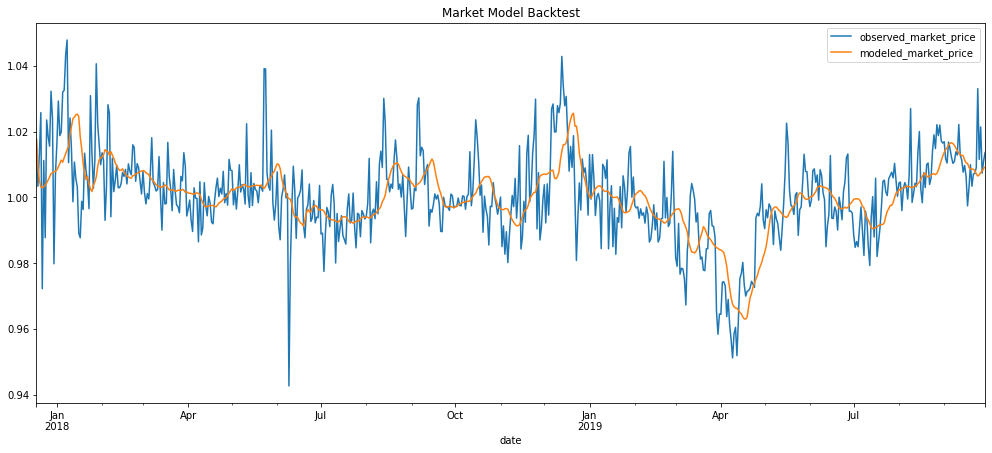

In [9]:
modeled_market_price = [df['p'].iloc[0]]
prev_e_hat = 0
prev_e_star = 0
cumsum_e_hat = 0
cumsum_e_star = 0
for i,r in df.iterrows():
    p = modeled_market_price[-1]
    e_hat = r['p_hat'] - p
    e_star = r['p_star'] - p
    cumsum_e_hat += e_hat
    cumsum_e_star += e_star
    delta_e_hat = e_hat - prev_e_hat
    delta_e_star = e_star - prev_e_star
    pred = sum([eval(v) * results.params[v] for v in input_vars]) + results.params['const']
    modeled_market_price.append(pred)

backtest_df = pd.DataFrame()
backtest_df['observed_market_price'] = df['p']
backtest_df['modeled_market_price'] = modeled_market_price[:-1]
backtest_df.plot(y=['observed_market_price','modeled_market_price'], figsize=(17,7), 
                 title='Market Model Backtest');

## Summary
A model of the dynamics that dictate the price of Single Collateral DAI was built based on the assumption that the market moves in response to two "attractors": 
* the target price, which for Single Collateral DAI was constant and equal to 1; and
* the "debt price", a sort of "intrinsic value" of DAI which manifests as activity in the debt market.

Given the modular nature of the debt price estimator, a target price controller can be tuned and tested by performing experiments driven either by hypothetical debt market activity signals or by hypotethical debt price valuation signals.